In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [12]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("C:/Users/dude/Downloads/cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()


,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [13]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


In [19]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
cad_jpy_df['Return'] = cad_jpy_df.Price.pct_change() * 100
cad_jpy_df = cad_jpy_df.resample('D').mean()
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.tail()

,Price,Open,High,Low,Return
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


In [64]:
# Create a lagged return using the shift function
Returns = cad_jpy_df.Price.pct_change() * 100
Returns = Returns.resample('D').mean()
Returns = Returns.dropna()
cad_jpy_df['Lagged_Return'] = Returns.shift()
# Drop NaN values
cad_jpy_df = cad_jpy_df.replace(-np.inf, np.nan).dropna()

In [65]:
cad_jpy_df.tail()

,Price,Open,High,Low,Return,Lagged_Return
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


In [29]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [45]:
# Create dataframes for X_train and X_test
# Create series for y_train and y_test
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
Y_train = train["Return"]
Y_test = test["Return"]

In [46]:
X_train.head()

,Lagged_Return
Date,
1990-01-15,0.119190
1990-01-16,-0.619048
1990-01-17,-0.223606
1990-01-18,-0.144069
1990-01-19,0.096185


In [47]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

In [48]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [57]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test) 

In [66]:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

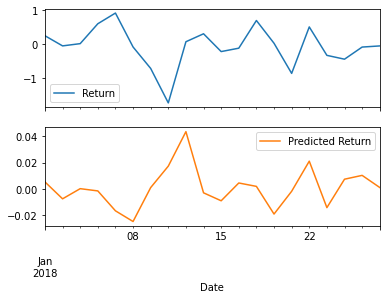

In [67]:
Results[:20].plot(subplots=True)

In [68]:
#evaluate out-of-sample data
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

In [69]:
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445771349043468


In [70]:
# Construct a DataFrame using just the "y" training data:
in_sample_results = Y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.8420928521561356


In [71]:
#Question: Does this model perform better or worse on out-of-sample data as compared to in-sample data?
#Answer: it performs better with the in-sample Data